# Music Classification System

In [44]:
# install packages
!pip install inflect
!pip install vaderSentiment
!pip install textblob
!pip install flair
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install imblearn

You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


Requirement already up-to-date: tensorflow in c:\users\kevinzhenshuai\anaconda3\lib\site-packages (2.3.1)

You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.



Requirement already up-to-date: keras in c:\users\kevinzhenshuai\anaconda3\lib\site-packages (2.4.3)


You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\kevinzhenshuai\anaconda3\python.exe -m pip install --upgrade pip' command.


## Import necessary libraries

In [15]:
import json
import pandas as pd
import string
import re
import time
from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import html
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from flair.embeddings import FlairEmbeddings, BertEmbeddings, WordEmbeddings, DocumentRNNEmbeddings

import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D, LSTM
from tensorflow.keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Reshape
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix, coo_matrix

from textblob import TextBlob

from keras.layers import Input, Embedding, Dot, Reshape, Dense,concatenate, Bidirectional,LSTM
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint

## Import data files

Training Data

In [16]:
trainList = []
print("Started Reading JSON file which contains multiple JSON document")
with open("train.json", "r") as f:
    for jsonObj in f:
        trainDict = json.loads(jsonObj)
        trainList.append(trainDict)
        
trainDF = pd.DataFrame(data = trainList)
trainDF.info()
trainDF.head()

Started Reading JSON file which contains multiple JSON document
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         200000 non-null  float64
 1   reviewTime      200000 non-null  object 
 2   reviewerID      200000 non-null  object 
 3   reviewText      199964 non-null  object 
 4   summary         199965 non-null  object 
 5   unixReviewTime  200000 non-null  int64  
 6   category        200000 non-null  object 
 7   price           200000 non-null  object 
 8   itemID          200000 non-null  object 
 9   reviewHash      200000 non-null  object 
 10  image           463 non-null     object 
dtypes: float64(1), int64(1), object(9)
memory usage: 16.8+ MB


,overall,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category,price,itemID,reviewHash,image
0,4.0,"08 24, 2010",u04428712,"So is Katy Perry's new album ""Teenage Dream"" c...",Amazing that I Actually Bought This...More Ama...,1282608000,Pop,$35.93,p70761125,85559980,NaN
1,5.0,"10 31, 2009",u06946603,"I got this CD almost 10 years ago, and given t...",Excellent album,1256947200,Alternative Rock,$11.28,p85427891,41699565,NaN
2,4.0,"10 13, 2015",u92735614,I REALLY enjoy this pairing of Anderson and Po...,"Love the Music, Hate the Light Show",1444694400,Pop,$89.86,p82172532,24751194,NaN
3,5.0,"06 28, 2017",u35112935,Finally got it . It was everything thought it ...,Great,1498608000,Pop,$11.89,p15255251,22820631,NaN
4,4.0,"10 12, 2015",u07141505,"Look at all star cast. Outstanding record, pl...",Love these guys.,1444608000,Jazz,$15.24,p82618188,53377470,NaN


Test Data

## Data Cleaning and Preparation

Denoise Text

In [17]:
def html_escaping(text):
    '''html escaping: Html character codes (i.e., &...;) are replaced with an ASCII equivalent'''
    return html.unescape(text)

def to_lower(text):
    '''lower case all words in text'''
    return text.lower()

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    '''remove urls'''
    return re.sub(r"http\S+", ' ', text)

def remove_punctuation(text):
    '''Remove punctuation from text'''
    for char in string.punctuation:
        text = text.replace(char,' ')
    return text
        
def denoise_text(text):
    text = str(text) # make sure all inputs are type string
    text = to_lower(text)
    text = strip_html(text)
    text = html_escaping(text)
    text = remove_between_square_brackets(text)
    text = remove_punctuation(text)
    return text

Tokenize and normalize text

In [18]:
def word_extraction(text):    
    '''removing stopwords from the sentence and tokenize the sentence'''
    stopWords = stopwords.words('english')
    # append words with puncutations stripped
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in stopWords]
    stopWords.extend(stripped)
    # remove duplicates for runtime
    stopWords= list(dict.fromkeys(stopWords))
    
    ignore = stopWords   
    words = re.sub("[^\w]", " ",  text).split()    
    cleaned_words = [w for w in words if w not in ignore]    
    return cleaned_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def detokenize_text(words):
    '''detokenize words into a text string'''
    return ' '.join(words)

def normalize_text(text):
    words = word_extraction(text)
    #words = lemmatize_verbs(words)
    words = stem_words(words)
    text = detokenize_text(words)
    return text

### Categorical Data

#### Reviewer ID

In [19]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(trainDF.reviewerID)
encoded_reviewerID = encoder.transform(trainDF.reviewerID)
trainDF['userID'] = encoded_reviewerID

#### unixReviewTime

In [20]:
def get_weekday(unixTime):
    '''Extact Weekday as locale’s abbreviated name from unixReviewTime as the feature'''
    return datetime.fromtimestamp(unixTime, timezone.utc).strftime("%A")

def get_year(unixTime):
    return int(datetime.fromtimestamp(unixTime,timezone.utc).strftime('%Y'))

In [21]:
#TRAIN -------------------------------------------------------
trainDF['weekday'] = trainDF['unixReviewTime'].apply(lambda x: get_weekday(x))
trainDF['year'] = trainDF['unixReviewTime'].apply(lambda x: get_year(x))

In [22]:
trainDF['weekday'].value_counts()

Tuesday      32180
Wednesday    29868
Monday       29066
Thursday     28796
Friday       28243
Saturday     26427
Sunday       25420
Name: weekday, dtype: int64

#### price

training data

In [23]:
trainDF['price'] = trainDF['price'].str.replace('$', '')
trainDF['price'] = trainDF['price'].apply(lambda x : pd.to_numeric(x,errors = 'coerce'))

In [24]:
# There are several methods to determine how to handle NaN values 
#- including dropping them, filling with mode or mean, or replacing with an "Other" value
# start with data exploration - can check if there a pattern in where the NaN values appear or if the rows with NaN are randomly distributed

# For Example - is the a pattern in job categories where NaN contract type appears or is it similar to the full data set?

a = trainDF['category'].value_counts(normalize=True)
b = trainDF[trainDF['price'].isnull()]['category'].value_counts(normalize=True)
print (pd.DataFrame({'Alldata': a, 'NaN Price':b,'ratio':b/a}))

                     Alldata  NaN Price     ratio
Alternative Rock    0.283790   0.357012  1.258015
Classical           0.094275   0.082754  0.877789
Dance & Electronic  0.062630   0.050165  0.800970
Jazz                0.098930   0.072867  0.736552
Pop                 0.460375   0.437202  0.949666


In [25]:
# fill null price with mode
trainDF['price'].fillna(trainDF['price'].mode()[0],inplace=True)

#### Target variable: category 

In [26]:
trainDF.category.value_counts()

Pop                   92075
Alternative Rock      56758
Jazz                  19786
Classical             18855
Dance & Electronic    12526
Name: category, dtype: int64

In [27]:
trainDF.groupby('category')['price'].mean()

category
Alternative Rock      12.235644
Classical             18.253591
Dance & Electronic    12.780753
Jazz                  14.267939
Pop                   13.650443
Name: price, dtype: float64

In [29]:
train_target = pd.get_dummies(data=trainDF['category'], columns=['category'])

### NLP on text data

#### reviewText

In [30]:
%%time

#TRAIN -------------------------------------------------------
trainDF['reviewText'] = trainDF['reviewText'].apply(lambda x: denoise_text(x)) 
trainDF['reviewText'] = trainDF['reviewText'].apply(lambda x: normalize_text(x)) 

C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b003hjwjy6?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_2" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Wall time: 6min 11s


#### Summary

In [31]:
%%time
#TRAIN -------------------------------------------------------
trainDF['summary'] = trainDF['summary'].apply(lambda x: denoise_text(x)) 
trainDF['summary'] = trainDF['summary'].apply(lambda x: normalize_text(x))

C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "......." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: ".." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\kevinzhenshuai\anacond

Wall time: 1min 50s


In [32]:
%%time
#replace null summary with review text, vice versa. Drop null column when both are empty entries
trainDF.loc[trainDF.summary =='', 'summary'] = trainDF.reviewText
trainDF.loc[trainDF.reviewText =='', 'reviewText'] = trainDF.summary
trainDF = trainDF.loc[trainDF.summary !=''].loc[trainDF.reviewText !=''].reset_index(drop = True)

Wall time: 262 ms


### Text Embedding

#### reviewText

,bins,counts
0,0-100,156161
1,100-300,37562
2,300-500,4909
3,>500,1353


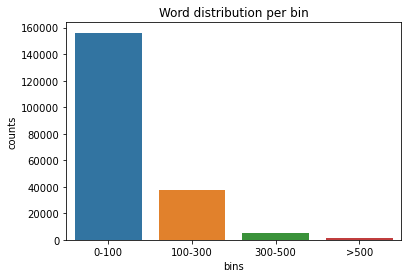

In [33]:
words_reviewText =pd.DataFrame({'count':trainDF.reviewText.apply(lambda x : len(x.split()))})

words_reviewText['bins'] =pd.cut(words_reviewText['count'], bins=[0,100,300,500,np.inf], labels=['0-100', '100-300', '300-500','>500'])
reviewText_distribution = words_reviewText.groupby('bins').size().reset_index().rename(columns={0:'counts'})

sns.barplot(x='bins', y='counts', data=reviewText_distribution).set_title("Word distribution per bin")
reviewText_distribution.head()

In [34]:
%%time
# since word count more than 500 is less than majority
MAX_LENGTH_reivewText = 500
tokenizer = Tokenizer()

Wall time: 998 µs


In [35]:
# embed reviewText
tokenizer.fit_on_texts(trainDF.reviewText.values)
reviewText_train_seq = tokenizer.texts_to_sequences(trainDF.reviewText.values)
reviewText_train_padded = pad_sequences(reviewText_train_seq, maxlen=MAX_LENGTH_reivewText)
print("reviewText train vocabulary size %g\n" %(len(tokenizer.word_index) + 1))

reviewText train vocabulary size 100817



In [36]:
vocab_reviewText = 103450

,bins,counts
0,0-5,179400
1,5-10,18997
2,10-25,1123
3,>25,465


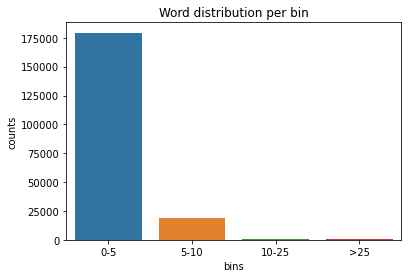

In [37]:
words_summary =pd.DataFrame({'count':trainDF.summary.apply(lambda x : len(x.split()))})

words_summary['bins'] =pd.cut(words_summary['count'], bins=[0,5,10,25,np.inf], labels=['0-5', '5-10', '10-25','>25'])
summary_distribution = words_summary.groupby('bins').size().reset_index().rename(columns={0:'counts'})

sns.barplot(x='bins', y='counts', data=summary_distribution).set_title("Word distribution per bin")
summary_distribution.head()

In [38]:
# since word count more than 800 is less than 500.
MAX_LENGTH_summary = 25
tokenizer = Tokenizer()

In [39]:
# embed summary
tokenizer.fit_on_texts(trainDF.summary.values)
summary_train_seq = tokenizer.texts_to_sequences(trainDF.summary.values)
summary_train_padded = pad_sequences(summary_train_seq, maxlen=MAX_LENGTH_summary)
print("summary train vocabulary size %g\n" %(len(tokenizer.word_index) + 1))

summary train vocabulary size 21501



In [40]:
vocab_summary = 22000

In [74]:
#embedding col names of review text and summary
review_emb_schema = []
for i in range(1,reviewText_train_padded.shape[1]+1):
    review_emb_schema.append('review_emb_'+str(i))

summary_emb_schema = []
for i in range(1,summary_train_padded.shape[1]+1):
    summary_emb_schema.append('summary_emb_'+str(i))

In [80]:
reviewTextDF = pd.DataFrame(reviewText_train_padded, columns = review_emb_schema)
summaryDF = pd.DataFrame(summary_train_padded, columns = summary_emb_schema)

In [86]:
X = pd.concat([reviewTextDF, summaryDF,trainDF['userID']],axis = 1)
y = trainDF['category'].astype('category').cat.codes

In [101]:
dict_y = dict(enumerate(trainDF['category'].astype('category').cat.categories))
dict_y

{0: 'Alternative Rock',
 1: 'Classical',
 2: 'Dance & Electronic',
 3: 'Jazz',
 4: 'Pop'}

#### Further Split Training Data into Training and Validation Set

In [104]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE('minority')
# X_sm,y_sm = smote.fit_sample(X,y)

C:\Users\kevinzhenshuai\anaconda3\lib\site-packages\imblearn\utils\_validation.py:635: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.9 "


In [211]:
# y_enc = pd.concat([pd.DataFrame(y_sm, columns=['category']),pd.get_dummies(data = y_sm, columns = 'category')],axis = 1)
y_enc = pd.concat([pd.DataFrame(y, columns=['category']),pd.get_dummies(data = y, columns = 'category')],axis = 1)

In [106]:
print(X_sm.shape, X.shape)
print(y_sm.shape, y.shape)

(279525, 526) (199985, 526)
(279525,) (199985,)


In [212]:
# RRP_x_train, RRP_x_val, RRP_y_train, RRP_y_val = train_test_split(X_sm, y_enc , random_state=42, test_size=0.3)
RRP_x_train, RRP_x_val, RRP_y_train, RRP_y_val = train_test_split(X, y_enc , random_state=42, test_size=0.3)

## Model Implementation

In [221]:
def embedding_model(MAX_LENGTH_reivewText,MAX_LENGTH_summary):
    review_inputs = Input(shape=(MAX_LENGTH_reivewText, ),name = 'review_input')
    review_emb = Embedding(vocab_reviewText,
                                32,
                                input_length=MAX_LENGTH_reivewText,
                                name = 'review_emb')(review_inputs)
    review_out = Flatten()(review_emb)

    summary_inputs = Input(shape=(MAX_LENGTH_summary, ),name = 'summary_inputs')
    summary_emb = Embedding(vocab_summary,
                                32,
                                input_length=MAX_LENGTH_summary,
                                name = 'summary_emb')(summary_inputs)
    summary_out = Flatten()(summary_emb)
    # dot = Dot(name = 'dot', normalize = True, axes = 2)([review_emb,summary_emb])
    # merged = Flatten()(dot)
    # merged = Reshape(target_shape = [-1,625])(merged)
    merged = concatenate([review_out, summary_out])

    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001))(user_vec)
    x = Dropout(0.1)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=[review_inputs,summary_inputs], outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    model.summary()
    return model

In [222]:
model = embedding_model(MAX_LENGTH_reivewText,MAX_LENGTH_summary)
filepath="weights-simple.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit([RRP_x_train[review_emb_schema],RRP_x_train[summary_emb_schema]], batch_size=32, y=RRP_y_train.drop('category',axis = 1), verbose=1, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

Model: "functional_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_input (InputLayer)       [(None, 500)]        0                                            
__________________________________________________________________________________________________
summary_inputs (InputLayer)     [(None, 25)]         0                                            
__________________________________________________________________________________________________
review_emb (Embedding)          (None, 500, 32)      3310400     review_input[0][0]               
__________________________________________________________________________________________________
summary_emb (Embedding)         (None, 25, 32)       704000      summary_inputs[0][0]             
______________________________________________________________________________________

In [223]:
# verify mse with best model on validation set
prob_textModel = model.predict([RRP_x_val[review_emb_schema],RRP_x_val[summary_emb_schema]])
predicted_textModel = np.argmax(prob_textModel, axis=1)

In [224]:
acc1 = accuracy_score(RRP_y_val['category'], predicted_textModel)
acc1

0.6987465831055404

### Classifier based on Reviewer ID

In [215]:
RRP_x_train.userID.value_counts()

29286    332
61258    317
26681    244
37512    216
4714     192
        ... 
64162      1
58017      1
60064      1
70303      1
2047       1
Name: userID, Length: 60882, dtype: int64

In [216]:
RRP_y_train

,category,0,1,2,3,4
120269,4,0,0,0,0,1
85018,3,0,0,0,1,0
169705,0,1,0,0,0,0
173203,4,0,0,0,0,1
12292,4,0,0,0,0,1
...,...,...,...,...,...,...
119879,1,0,1,0,0,0
103694,0,1,0,0,0,0
131932,4,0,0,0,0,1
146867,4,0,0,0,0,1


In [217]:
EMBEDDING_SIZE = 32 
NUM_USERS = trainDF['userID'].nunique()+5
ROW_COUNT = RRP_x_train.shape[0]

def EmbeddingRec(EMBEDDING_SIZE, NUM_USERS, ROW_COUNT):
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001))(user_vec)
    x = Dropout(0.1)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=user_input, outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    model.summary()
    return model, user_model

reviewID_model,user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_USERS,ROW_COUNT)
filepath="userID_embeddingModel.hdf5"

callbacks = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# fit network
history = reviewID_model.fit(RRP_x_train['userID'], y=RRP_y_train.drop('category',axis=1), epochs =10,
                            verbose = 1, 
                            callbacks = callbacks)

Model: "functional_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_id (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
user_emb (Embedding)         (None, 1, 32)             2313216   
_________________________________________________________________
FlattenUser (Flatten)        (None, 32)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_47 (Dense)             (None, 5)                 165       
Total params: 2,314,437
Trainable params: 2,314,437
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
4375/4375 [==============================] - 84s 19ms/step - loss: 1.1486 - acc: 0.5584
Epoch 2/10

In [218]:
# verify mse with best model on validation set
prob_userModel = reviewID_model.predict(RRP_x_val['userID'])

In [219]:
predicted_userModel = np.argmax(prob_userModel, axis=1)

In [220]:
acc2 = accuracy_score(RRP_y_val['category'], predicted_userModel)
acc2

0.5922394826321755

### Model Ensembling

In [225]:
w1 = acc1/(acc1+acc2)
w2 = 1- w1
prob = w1*prob_textModel + w2*prob_userModel
predicted = np.argmax(prob,axis = 1)

In [226]:
accuracy_score(RRP_y_val['category'], predicted)

0.7250983398893259

#### All potentially related embeddings concatenated in the neural network

In [227]:
EMBEDDING_SIZE = 32
NUM_USERS = trainDF['reviewerID'].nunique()+5
ROW_COUNT = RRP_x_train.shape[0]

def embeddingAll(MAX_LENGTH_reivewText,MAX_LENGTH_summary, EMBEDDING_SIZE, NUM_USERS, ROW_COUNT):
    review_inputs = Input(shape=(MAX_LENGTH_reivewText, ),name = 'review_input')
    review_emb = Embedding(vocab_reviewText,
                                32,
                                input_length=MAX_LENGTH_reivewText,
                                name = 'review_emb')(review_inputs)
    review_out = Flatten()(review_emb)

    summary_inputs = Input(shape=(MAX_LENGTH_summary, ),name = 'summary_inputs')
    summary_emb = Embedding(vocab_summary,
                                32,
                                input_length=MAX_LENGTH_summary,
                                name = 'summary_emb')(summary_inputs)
    summary_out = Flatten()(summary_emb)
    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_out = Flatten(name='FlattenUser')(user_emb)
    
    # dot = Dot(name = 'dot', normalize = True, axes = 2)([review_emb,summary_emb])
    # merged = Flatten()(dot)
    # merged = Reshape(target_shape = [-1,625])(merged)
    merged = concatenate([review_out, summary_out, user_out])

    x = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.001))(user_vec)
    x = Dropout(0.1)(x)
    predictions = Dense(5, activation='softmax')(x)
    model = Model(inputs=[review_inputs,summary_inputs,user_input], outputs=predictions)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    model.summary()
    return model

In [228]:
model_embed = embeddingAll(MAX_LENGTH_reivewText,MAX_LENGTH_summary, EMBEDDING_SIZE, NUM_USERS, ROW_COUNT)
filepath="model_embed.hdf5"
checkpointer = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history = model_embed.fit([RRP_x_train[review_emb_schema],RRP_x_train[summary_emb_schema],RRP_x_train['userID']], batch_size=32, y=RRP_y_train.drop('category',axis = 1),  verbose=1, 
          shuffle=True, epochs=5, callbacks=[checkpointer])

Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
review_input (InputLayer)       [(None, 500)]        0                                            
__________________________________________________________________________________________________
summary_inputs (InputLayer)     [(None, 25)]         0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
review_emb (Embedding)          (None, 500, 32)      3310400     review_input[0][0]               
______________________________________________________________________________________

In [231]:
# verify mse with best model on validation set
prob_embedModel = model.predict([RRP_x_val[review_emb_schema],RRP_x_val[summary_emb_schema],RRP_x_val['userID']])
prob_embedModel = np.argmax(prob_embedModel, axis=1)

In [232]:
accuracy_score(RRP_y_val['category'], prob_embedModel)

0.6987465831055404